# Overview of the Gradient Boosted Tree Classifier

Gradient Boosting is an ensemble learning method that takes many weak learners (with accuracy slightly above that of a random guess) and combines them sequentially to create a strong learner (model accuracy of >95%).

Advantages:
- Highly interpretable - the steps are intuitive
- Versatile - can be used for both classification and regression problems

Disadvantages:
- If the hyperparameters aren't tuned carefully, it is easy for the model to overfit the training data
- The model can become computationally expensive, as it requires subsequently training multiple weak learners

### Representation

We have chosen to implement Gradient Boosting for a classification problem, using a shallow decision tree as our weak learner. The final model $F(x)$ is therefore built from a sequence of $N$ trees, where each successive tree corrects the predictions from the previous iteration:

$F_{N}(x) = F_{0}(x) + \eta \sum_{i=1}^{N} h_{i}(x)$ 

Where:
- $F_{0}(x)$ is the initial prediction
- $\eta$ is the learning rate (a value between 0 and 1)
- $h_{i}(x)$ is the prediction made by decision tree $i$, trained on the residuals from the previous trees

We are not predicting class labels, but are instead predicting pseudo-residuals that will be used to correct the initial prediction.

### Loss

As this is a binary classification problem we will be using the Cross-Entropy loss/Log loss as our loss function. The function is:

$L(y, \hat{p}(x)) = -(y \cdot log(\hat{p}(x)) + (1-y) \cdot log(1-\hat{p}(x)))$

Where:
- $y$ are the true labels, 1 or 0
- $\hat{p}(x)$ is the probability predictor for the positive class, 1

### Optimizer

The optimizer is gradient descent on the pseudo-residuals

We calculate the pseudo-residuals as the negative gradient of the loss function with respect to the current model prediction:

$r_i = -\frac{\partial L(y, \hat{p}(x))}{\partial F(x)} = y - \hat{p}(x)$

Shallow decision trees are trained on the previous iteration residuals, which are then used to update the prediction

$F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$ 

### Algorithm Pseudocode

**inputs:**

*training set:* $S = (x_1, y_1), ... , (x_m, y_m)$

*weak learner: decision tree classifier* $DTC$

*number of trees:* $N$

*learning rate:* $\eta$

**initialize:**

*set initial predictions as log-odds of the positive class:* $F_{0}(x) = logit(p_{y=1}) = log(\frac{p_{y=1}}{1-p_{y=1}})$ 

**for** $i = 0, ...,N-1:$

*compute the residuals:* $r_i = -\frac{\partial L(y, \hat{p}_{i}(x))}{\partial F_{i}(x)} = y - \hat{p}_{i}(x)$

*train a weak learner with residuals as targets:* $h_{i}(x) = DTC(F_{i}(x), S)$

*update the model:* $F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$

**output:** 

*the predictions* $\hat{y} = argmax(F_{N}(x))$


# Model

In [ ]:
import numpy as np
import math

def cal_mse(y):
    if len(y) == 0:
        return 0
    
    mean = np.mean(y)

    return np.mean((y - mean) ** 2)

### Weak Learner: Decision Tree

In [ ]:
class Node:
    def __init__(self, left=None, right=None, depth=0, index_split_on=0, isleaf=False, threshold=None, value=None):
        self.left = left
        self.right = right
        self.depth = depth
        self.index_split_on = index_split_on
        self.isleaf = isleaf
        self.threshold = threshold

        self.value = value
        self.leaf_id = None

class DecisionTree:
    def __init__(self, X, y, max_depth=40, min_samples_split=2, min_samples_leaf=1):
        
        self.average_value = np.mean(y)
        self.max_depth = max_depth
        self.root = Node(value=self.average_value)
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        indices = list(range(1, X.shape[1]+1))
        self.leaf_id_counter = 1
        self.value = []
        self._split_recurs(self.root, X, y, indices)
        
    def predict(self, X):

        predictions = []
        for i in range(X.shape[0]):
            row = X[i,:]
            predictions.append(self._predict_recurs(self.root, row))
        return np.array(predictions)

    def _predict_recurs(self, node, row):

        if node.isleaf or node.index_split_on == 0:
            return node.value

        if row[node.index_split_on-1] <= node.threshold:
            return self._predict_recurs(node.left, row)
        
        else:
            return self._predict_recurs(node.right, row)
        

    def _is_terminal(self, node, X, y, indices):

        node.isleaf = False
        node.value = np.mean(y)

        # Terminate if fewer than `min_samples_split`
        if len(y) < self.min_samples_split:
            node.isleaf = True

        # Terminate if fewer than `min_samples_leaf` would remain in a split
        if len(y) > 0 and len(y) <= self.min_samples_leaf:
            node.isleaf = True

        if len(indices) == 0:
            node.isleaf = True
        
        if len(set(y)) == 1:
            node.isleaf = True

        if node.depth == self.max_depth:
            node.isleaf = True

        if node.isleaf == True:
            node.leaf_id = self.leaf_id_counter
            self.leaf_id_counter += 1
            self.value.append(node.value)

        return node.isleaf, node.value

    def find_threshold(self, X, y, mse, indices):
        # find the best index and threshold value for the selected index
        best_mse = mse
        best_idx = None
        best_thresh = None

        for idx in indices:
            #thresholds = np.unique(X[:, idx-1])
            #thresholds = np.linspace(min(X[:,idx-1])/2, max(X[:,idx-1])*2, 10000)
            sorted_X = np.sort(X[:,idx-1])
            thresholds = (sorted_X[:-1] + sorted_X[1:])/2
            for threshold in thresholds:
                
                left_idx = X[:, idx-1] <= threshold
                right_idx = X[:, idx-1] > threshold

                # Check `min_samples_leaf` condition
                if sum(left_idx) < self.min_samples_leaf or sum(right_idx) < self.min_samples_leaf:
                    mse = float('inf')
                else:
                    mse = cal_mse(y[left_idx])+cal_mse(y[right_idx])

                if mse < best_mse:
                    best_mse = mse
                    best_idx = idx
                    best_thresh = threshold

        return best_idx, best_thresh

    def _split_recurs(self, node, X, y, indices):

        node.isleaf, node.value = self._is_terminal(node, X, y, indices)

        mse = cal_mse(y)

        if not node.isleaf:
                
            best_idx, best_thresh = self.find_threshold(X, y, mse, indices)
            
            if best_idx == None:
                node.isleaf = True
                node.value = np.mean(y)
                return

            node.threshold = best_thresh
            node.index_split_on = best_idx

            left_idx = X[:, best_idx-1] <= best_thresh
            right_idx = X[:, best_idx-1] > best_thresh

            left_X, left_y = X[left_idx], y[left_idx]
            right_X, right_y = X[right_idx], y[right_idx]

            left_child = Node(depth=node.depth + 1)
            right_child = Node(depth=node.depth + 1)
            
            node.left = left_child
            node.right = right_child
            
            self._split_recurs(left_child, left_X, left_y, indices)
            self._split_recurs(right_child, right_X, right_y, indices)

    
    def apply(self, X):
        leaf_indices = []
        for i in range(X.shape[0]):
            row = X[i,:]
            leaf_indices.append(self._apply_recurs(self.root, row))
        return np.array(leaf_indices)

    def _apply_recurs(self, node, row):
        if node.isleaf:
            return node.leaf_id  # Return the unique leaf ID
        
        if row[node.index_split_on - 1] <= node.threshold:
            return self._apply_recurs(node.left, row)
        else:
            return self._apply_recurs(node.right, row)



### Weak Learner: Decision Tree (Scikit-Learn)

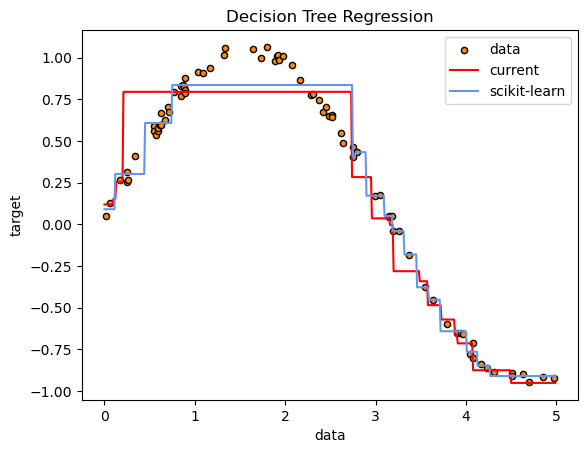

np.float64(0.014566577923735046)

In [ ]:
from sklearn.tree import DecisionTreeRegressor


X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() #+ np.random.rand(80) * 0.1

# Make predictions
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test = np.sin(X_test).ravel() #+ np.random.rand(500) * 0.1

# Create a decision tree regressor
regressor = DecisionTreeRegressor(max_depth=4, random_state=0)  # You can adjust the max_depth parameter

regressor.fit(X, y)
y_pred1 = regressor.predict(X_test)

reg = DecisionTree(X, y, max_depth=4)
y_pred2 = reg.predict(X_test)



# Plot the results
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred1, color="red", label="scikit-learn", linewidth=1)
plt.plot(X_test, y_pred2, color="cornflowerblue", label="current", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()
print(mean_squared_error(y_test, y_pred1))
print(mean_squared_error(y_test, y_pred2))

In [378]:
class Node:
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None


# Decision Tree Regressor Class
class RegressionTree:
    def __init__(self, n_feats = None, max_depth = 100, min_samples_split = 2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None ,
                 random_state=None ,max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0):
        
        self.root = None
        self.n_feats = n_feats
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, Y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.col = list(X.columns)
        self.root = self.growTree(X, Y)

    def growTree(self, X, Y, depth = 0):
        
        df = X.copy()
        df['y'] = Y
        
        ymean = np.mean(Y)
        
        self.mse = self.get_mse(Y, ymean)
        
        n_sample, n_feature = X.shape
        
        # stopping criteria
        if (depth >= self.max_depth or n_sample <= self.min_samples_split):
            leaf_value = np.mean(Y)
            return Node(value=leaf_value)

        feats_idxs = list(X.columns)

        best_feat, best_thresh = self.best_criteria(X, Y, feats_idxs)

        left_df, right_df = df[df[best_feat]<=best_thresh].copy(), df[df[best_feat]>best_thresh].copy()

        left = self.growTree(left_df.drop('y', axis=1), left_df['y'].values.tolist(), depth+1)
        right = self.growTree(right_df.drop('y', axis=1), right_df['y'].values.tolist(), depth+1)

        return Node(best_feat, best_thresh, left, right)
    
    
    # find out best criteria
    def best_criteria(self, X, Y, feats_idxs):
        
        df = X.copy()
        
        df['y'] = Y
        
        mse_base = self.mse
        
        best_feature = None
        best_thresh = None
        
        for feat in feats_idxs:
            
            xdf = df.sort_values(feat)
            
            x_mean = self.moving_average(xdf[feat], 2)

            for value in x_mean:
                left_y = xdf[xdf[feat] < value]['y'].values
                right_y = xdf[xdf[feat] >= value]['y'].values
                
                left_mean = 0
                right_mean = 0
                if len(left_y) > 0:
                    left_mean = np.mean(left_y)
                if len(right_y) > 0:
                    right_mean = np.mean(right_y)
                
                res_left = left_y - left_mean
                res_right = right_y - right_mean
                
                r = np.concatenate((res_left, res_right), axis=None)
                
                n = len(r)

                r = r ** 2
                r = np.sum(r)
                mse_split = r / n
                
                if mse_split < mse_base:
                    mse_base = mse_split
                    best_feature = feat
                    best_thresh = value
                    
        return (best_feature, best_thresh)
    
    def get_mse(self, y_true, y_hat):
        n = len(y_true)
        
        r = y_true - y_hat
        
        r = r ** 2
        
        r = np.sum(r)
        
        return r / n
    
    def moving_average(self, x:np.array, window : int):
        return np.convolve(x, np.ones(window), 'valid') / window 
    
    def predict(self, X):
        X = X.to_numpy().tolist()
        
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, x, node):
       
        if node.value is not None:
            return node.value
        
        fr = node.feature
        index = self.col.index(fr)

        if x[index] <= node.threshold:
            return self.traverse_tree(x, node.left)
        
        return self.traverse_tree(x, node.right)

### Gradient Boosting

In [ ]:
class GBDTC:
    def __init__(self, n_estimators=2, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.init_val = None
        self.trees = None
        self.gamma_value = None
        
    def fit(self, X, y):
        # X: 2D numpy array for input variables
        # y: 1D numpy array for output variables
        prob = np.zeros([self.n_estimators+1,X.shape[0]])
        gamma = np.zeros([self.n_estimators,X.shape[0]])
        self.gamma_value = np.zeros([self.n_estimators,X.shape[0]])
        F = np.zeros((self.n_estimators+1,X.shape[0]))

        self.init_val = np.log(sum(y==1)/(X.shape[0]-sum(y==1)))

        prob[0,:] = np.full(X.shape[0], self.init_val)
        F[0,:] = np.full(X.shape[0], np.exp(self.init_val)/(1+np.exp(self.init_val)))

        self.residuals = np.zeros((self.n_estimators,X.shape[0]))
        self.trees = []

        for i in range(self.n_estimators):

            # calculate the residual
            self.residuals[i] = y-F[i,:]

            # tree = DecisionTreeRegressor(max_depth=self.max_depth)
            # tree.fit(X, self.residuals[i])
            
            # self.trees.append(tree)
            # tree = tree.tree_
            # leaf_indices=tree.apply(X) # total leaves in a tree [1 2 2 2 2 1]

            tree = DecisionTree(X, self.residuals[i], max_depth=self.max_depth)
            self.trees.append(tree)
            leaf_indices = tree.apply(X)

            unique_leaves=np.unique(leaf_indices) # [1 2]

            for idx in unique_leaves:
                n_leaf = len(leaf_indices[leaf_indices==idx])
                p_old = F[i][leaf_indices==idx]
                denominator = np.sum(p_old*(1-p_old))
                #self.gamma_value[i,idx] = tree.value[idx][0][0]*n_leaf / denominator
                self.gamma_value[i,idx] = tree.value[idx-1]*n_leaf / denominator

            gamma[i] = [self.gamma_value[i][index] for index in leaf_indices]

            prob[i+1,:] =  prob[i] + self.learning_rate * gamma[i]
            F[i+1,:] = np.array([np.exp(prob_elem)/(np.exp(prob_elem)+1) for prob_elem in prob[i+1,:]])


    def predict(self, X):

        prob = np.zeros([self.n_estimators+1,X.shape[0]])
        gamma = np.zeros([self.n_estimators,X.shape[0]])
        F = np.zeros((self.n_estimators+1,X.shape[0]))

        prob[0,:] = np.full(X.shape[0], self.init_val)
        F[0,:] = np.full(X.shape[0], np.exp(self.init_val)/(1+np.exp(self.init_val)))

        for i in range(self.n_estimators):

            tree = self.trees[i]
            leaf_indices = tree.apply(X)

            gamma[i] = [self.gamma_value[i,index] for index in leaf_indices]

            prob[i+1,:] =  prob[i] + self.learning_rate * gamma[i]
            F[i+1,:] = np.array([np.exp(prob_elem)/(np.exp(prob_elem)+1) for prob_elem in prob[i+1,:]])

        predictions = (F[self.n_estimators]>0.5) * 1.0

        return predictions


# Check Model

### Unit test?

### Model Comparison with the Gradient Boosting Classifier from Scikit-Learn

In [ ]:

from sklearn.datasets import make_hastie_10_2
X, y = make_hastie_10_2(random_state=0)
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test = X[:2000], X[2000:,:]
y_train, y_test = y[:2000], y[2000:]



clf = GradientBoostingClassifier(n_estimators=4, learning_rate=0.1,
    max_depth=2).fit(X_train, y_train)

y_pred1 = clf.predict(X_test)
accuracy1 = np.sum(y_test==y_pred1)/len(y_test)

y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

model2 = GBDTC(n_estimators=4,
              learning_rate=0.1,
              max_depth=2)

model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
accuracy2 = np.sum(y_test==y_pred2)/len(y_test)


print(f'accuracy1={accuracy1}')
print(f'accuracy2={accuracy2}')

0.6326

### Iris Dataset

Model accuracy: 1.0


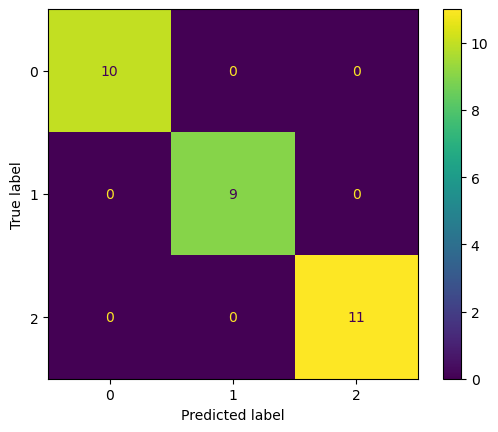

In [388]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
 
# Divide the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a CART template
tree_classifier = DecisionTreeClassifier(random_state=42)
 
#Train the model on the training data
tree_classifier.fit(X_train, y_train)

#Make predictions on test data
y_pred = tree_classifier.predict(X_test)
 
#Calculate the accuracy of the model<code>
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)
 
#View the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=tree_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tree_classifier.classes_)
disp.plot()
